# Mesh-Fitting

### Import and Functions

In [1]:
import os
import torch
import open3d
import pathlib

from pytorch3d.io import load_obj, save_obj
from pytorch3d.io import load_ply, save_ply
from pytorch3d.loss import chamfer_distance, mesh_edge_loss, mesh_laplacian_smoothing, mesh_normal_consistency
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.utils import ico_sphere

from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras,
    PointsRasterizationSettings,
    PointsRasterizer,
    PointsRenderer,
    AlphaCompositor,
)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation


def visualize_point_cloud(point_cloud):
    pcd = open3d.io.read_point_cloud(point_cloud)
    open3d.visualization.draw_geometries([pcd], mesh_show_wireframe=True)


def visualize_point_cloud2(verts, device, renderer):
    d_verts = (verts).to(device)
    rgb = torch.ones_like(d_verts).to(device)
    point_cloud = Pointclouds(points=[verts], features=[rgb])
    images = renderer(point_cloud)
    plt.figure(figsize=(10, 10))
    plt.imshow(images[0, ..., :3].cpu().numpy())
    plt.axis("off")


def visualize_point_cloud2_save(verts, device, renderer, index):
    d_verts = (verts).to(device)
    rgb = torch.ones_like(d_verts).to(device)
    point_cloud = Pointclouds(points=[verts], features=[rgb])
    images = renderer(point_cloud)
    plt.figure(figsize=(10, 10))
    plt.imshow(images[0, ..., :3].cpu().numpy())
    plt.axis("off")
    plt.savefig(f"./out/image{index}.png")


def visualize_mesh(mesh):
    print(f"Visualizing the mesh {mesh} using open3D")
    mesh = open3d.io.read_triangle_mesh(mesh, enable_post_processing=True)
    open3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True, mesh_show_back_face=True)


def delete_from_disk(path: pathlib.Path):
    if path.is_file() or path.is_symlink():
        path.unlink()
        return
    for p in path.iterdir():
        delete_from_disk(p)
    path.rmdir()


out_path = os.path.abspath("./out")
if os.path.isdir(out_path):
    delete_from_disk(pathlib.Path(out_path))
os.mkdir(out_path)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Renderer

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

# Initialize a camera.
# R, T = look_at_view_transform(20, 80, 360)
R, T = look_at_view_transform(dist=20, elev=80, azim=360)
cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)
raster_settings = PointsRasterizationSettings(image_size=512, radius=0.005, points_per_pixel=10)
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
renderer = PointsRenderer(rasterizer=rasterizer, compositor=AlphaCompositor())

### Initial Point Cloud

In [3]:
visualize_point_cloud("point_cloud.ply")
# visualize_mesh("point_cloud.ply")

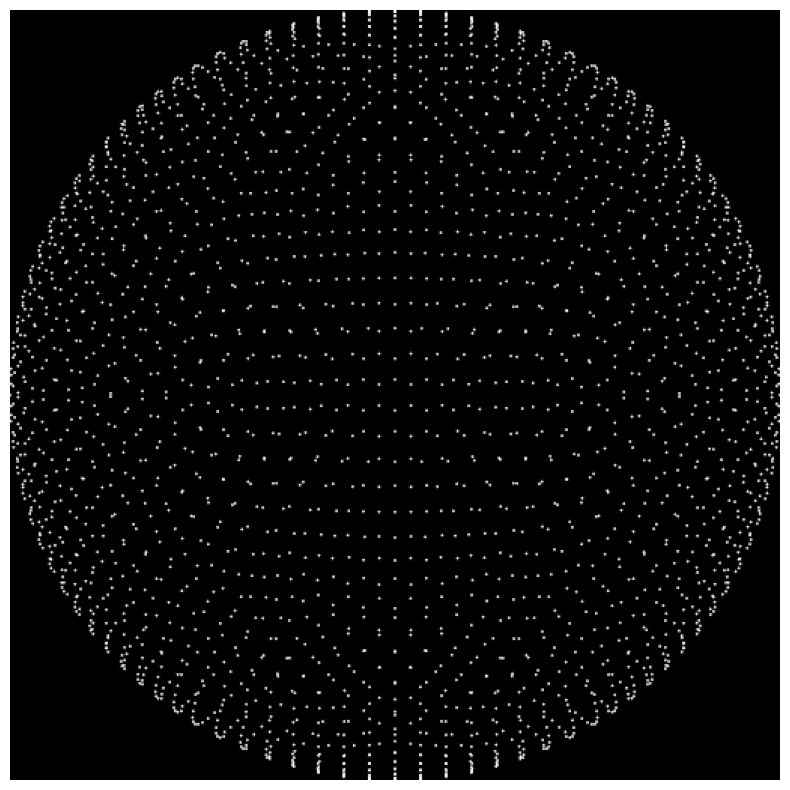

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

sphere_mesh = ico_sphere(4, device)
sphere_verts, sphere_faces = sphere_mesh.get_mesh_verts_faces(0)
sphere_ply = os.path.join(out_path, "sphere.ply")
save_ply(sphere_ply, sphere_verts, sphere_faces, ascii=True)

visualize_point_cloud2(sphere_verts, device, renderer)
# visualize_point_cloud(sphere_ply)

### Mesh-Fitting: Main

c:\tools\miniconda3\envs\torch3d\Lib\site-packages\pytorch3d\ops\laplacian_matrices.py:51: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:653.)
  A = torch.sparse.FloatTensor(idx, ones, (V, V))


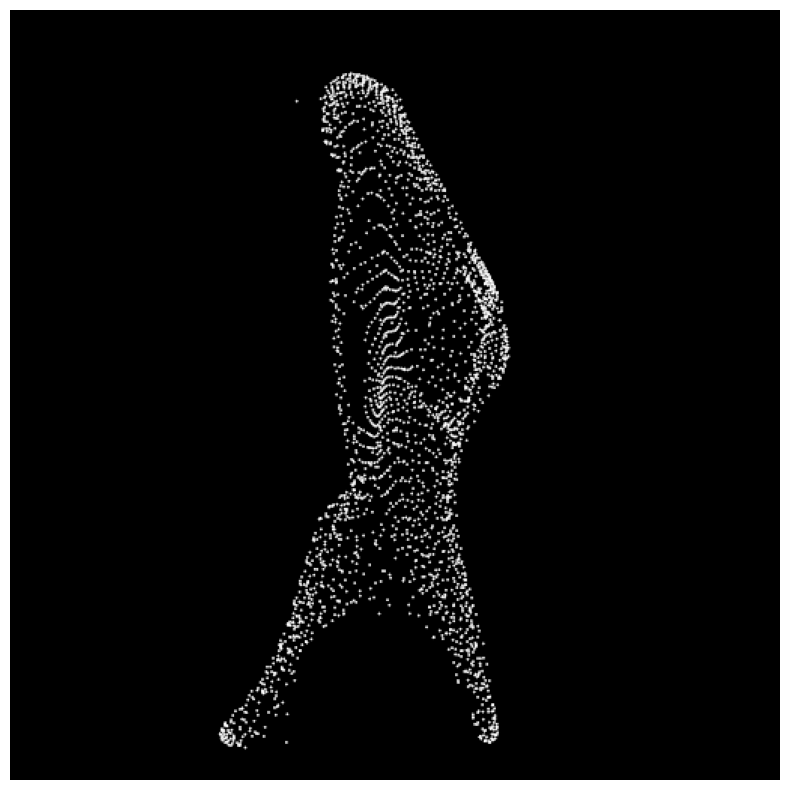

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

## Visualize the optimization process
img = []  # some array of images
frames = []  # for storing the generated images
fig = plt.figure(figsize=(10, 10))

verts, faces = load_ply("point_cloud.ply")
verts = verts.to(device)
faces = faces.to(device)

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale
verts = verts[None, :, :]

src_mesh = ico_sphere(4, device)
src_vert = src_mesh.verts_list()

deform_verts = torch.full(src_vert[0].shape, 0.0, device=device, requires_grad=True)

optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

w_chamfer = 1.0
w_edge = 1.0
w_normal = 0.01
w_laplacian = 0.1

for i in range(0, 2000):
    # print("i = ", i)

    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    # We sample 5k points from the surface of each mesh
    # sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_trg = verts
    sample_src = sample_points_from_meshes(new_src_mesh, verts.shape[1])

    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)

    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)

    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

    with torch.no_grad():
        vertices = (new_src_mesh.get_mesh_verts_faces(0)[0]).to(device)
        rgb = torch.ones_like(vertices).to(device)
        point_cloud = Pointclouds(points=[vertices], features=[rgb])
        images = renderer(point_cloud)
        # visualize_point_cloud2(vertices * 0.5, device, renderer)
        # plt.figure(figsize=(10, 10))
        # plt.imshow(images[0, ..., :3].cpu().numpy())
        # plt.axis("off")
        frames.append([plt.imshow(images[0, ..., :3].cpu().numpy(), animated=True)])

    # Optimization step
    loss.backward()
    optimizer.step()

final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)
final_verts_copy = final_verts.clone()
final_verts = final_verts * scale + center

plt.axis("off")
# plt.show()
anim = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
anim.save(os.path.join(out_path, "animation.mp4"))

# Store the predicted mesh using save_ply
deform1 = os.path.join(out_path, "deform1.ply")
save_ply(deform1, final_verts, final_faces, ascii=True)

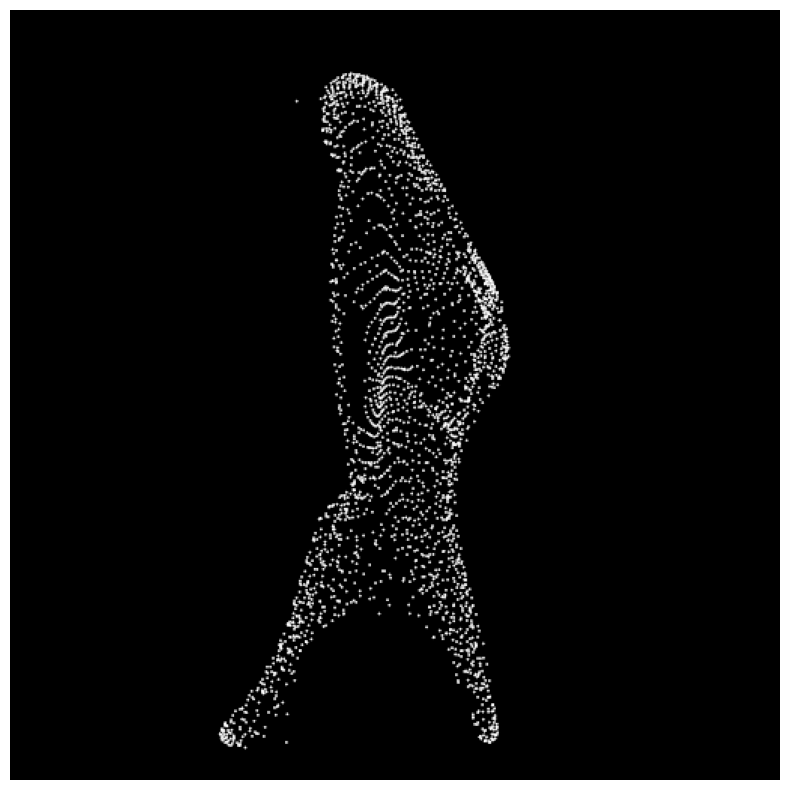

In [6]:
with torch.no_grad():
    visualize_point_cloud2(final_verts_copy, device, renderer)
# visualize_point_cloud(deform1)
# visualize_mesh(deform1)

### Mesh-Fitting: Without Regularization Loss Functions

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

verts, faces = load_ply("point_cloud.ply")
verts = verts.to(device)
faces = faces.to(device)

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale
verts = verts[None, :, :]

src_mesh = ico_sphere(4, device)
src_vert = src_mesh.verts_list()

deform_verts = torch.full(src_vert[0].shape, 0.0, device=device, requires_grad=True)

optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

w_chamfer = 1.0
w_edge = 0.0
w_normal = 0.0
w_laplacian = 0.0

for i in range(0, 2000):
    # print("i = ", i)

    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    # We sample 5k points from the surface of each mesh
    # sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_trg = verts
    sample_src = sample_points_from_meshes(new_src_mesh, verts.shape[1])

    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)

    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)

    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

    # Weighted sum of the losses
    loss = (loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian)

    # Optimization step
    loss.backward()
    optimizer.step()

final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)
final_verts = final_verts * scale + center

# Store the predicted mesh using save_ply
deform2 = os.path.join(out_path, "deform2.ply")
save_ply(deform2, final_verts, final_faces, ascii=True)

In [8]:
visualize_point_cloud(deform2)
# visualize_mesh(deform2)

### Mesh-Fitting: Chamfer + edge losses

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

verts, faces = load_ply("point_cloud.ply")
verts = verts.to(device)
faces = faces.to(device)

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale
verts = verts[None, :, :]

src_mesh = ico_sphere(4, device)
src_vert = src_mesh.verts_list()

deform_verts = torch.full(src_vert[0].shape, 0.0, device=device, requires_grad=True)

optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

w_chamfer = 1.0
w_edge = 1.0
w_normal = 0.0
w_laplacian = 0.0

for i in range(0, 2000):
    # print("i = ", i)

    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    # We sample 5k points from the surface of each mesh
    # sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_trg = verts
    sample_src = sample_points_from_meshes(new_src_mesh, verts.shape[1])

    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)

    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)

    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

    # Weighted sum of the losses
    loss = (loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian)

    # Optimization step
    loss.backward()
    optimizer.step()

final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)
final_verts = final_verts * scale + center

# Store the predicted mesh using save_ply
deform3 = os.path.join(out_path, "deform3.ply")
save_ply(deform3, final_verts, final_faces, ascii=True)

In [10]:
visualize_point_cloud(deform3)
# visualize_mesh(deform3)